<a href="https://colab.research.google.com/github/boshuaiYu/CaiCai_DL/blob/main/CaiCai_DL_Week6.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn,optim
import matplotlib.pyplot as plt
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/week4_function")
from torchLearning import *

$$y = \frac{x - \mathrm{E}[x]}{\sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

In [4]:
nn.BatchNorm1d?

- num_features：输入数据的特征数量（假设为n），也就是前一层神经元数量或原始数据集特征数量，根据此前的论述，BN层最终构建的是一个n*n的对角矩阵，对角线元素包含$\gamma$，并且截距项为$\beta$；
- eps：方差分母修正项，为了防止分母为0，一般取值为1e-5，也就是类默认值；
- affine：是否进行仿射变换，需要注意的是，此时进行仿射变换时将使用无偏估计进行期望和方差的计算，并且初始条件下$\gamma=1，\beta=0$，当参数取值为True时，会显式设置$\gamma和\beta$参数并带入进行梯度下降迭代计算，取值为False时，参数不显示，实际的数据归一化过程就是对原数据进行无偏估计下的Z-Score变换。
- momentum:关于momentum的设置，一般来说，为了尽可能获取到更加准确的训练集整体统计量，当每一个小批数据数据量比较小时，我们应该将历史数据比重调高，也就是降低momentum取值，以减少局部规律对获取总体规律的影响，当然，此时我们也需要增加遍历数据的次数epochs；而反之则可以考虑增大momentum取值。
- track_running_stats:对于BN来说，最后一个参数就是track_running_stats，默认取值为True。当此参数为True时，BN层会在每次迭代过程中会结合历史记录更新running_mean/var，当track_running_stats=False时，BN层将running_mean/var为None，并且在进行预测时会根据输入的小批数据进行均值和方差计算。在大多数情况下，并不推荐修改该参数的默认取值。

In [19]:
f = torch.arange(9).reshape(3,3).float()
f

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [6]:
bn1 = nn.BatchNorm1d(3)

In [7]:
bn1(f) # 样本方差

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

In [8]:
# Z-Score计算(无偏估计算的)

(f-torch.mean(f,0))/ torch.sqrt(torch.var(f,0))

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

> pytorch中默认的方差计算是样本无偏估计，而BN再进行归一化计算时实际上采用的是样本方差，二者区别如下，样本方差为：<font color="orange">$$Var(x) = \frac{\sum^n_{i=1}(x_i-\bar x)^2}{n}$$</font>但对样本整体方差的无偏估计为：$$Var_{unbiased}(x) = \frac{\sum^n_{i=1}(x_i-\bar x)^2}{n-1}$$

In [31]:
# 非无偏估计计算结果
(f-torch.mean(f,0))/torch.sqrt(torch.var(f,0,unbiased=False))

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]])

In [14]:
list(bn1.parameters())

[Parameter containing:
 tensor([1., 1., 1.], requires_grad=True), Parameter containing:
 tensor([0., 0., 0.], requires_grad=True)]

In [20]:
bn2 = nn.BatchNorm1d(3,affine=False) # 不可微
bn2(f)

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]])

&emsp;&emsp;为了能够获取训练数据整体均值和方差，BN采用了迭代累计计算的方法，通过类似动量法的方法对每一个小批数据的均值和方差进行累计统计，最终计算训练数据整体均值和方差

In [21]:
f = torch.arange(9).reshape(3,3).float()
f

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [25]:
bn1 = nn.BatchNorm1d(3)

In [26]:
bn1.running_mean,bn1.running_var

(tensor([0., 0., 0.]), tensor([1., 1., 1.]))

In [27]:
bn1(f)

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

<font color="orange">$$running\_mean = (1-momentum) * running\_mean + momentum * sample\_mean$$

In [28]:
bn1.running_mean

tensor([0.3000, 0.4000, 0.5000])

<font color="orange">$$running\_var = (1-momentum) * running\_var + momentum * sample\_var$$

In [29]:
bn1.running_var

tensor([1.8000, 1.8000, 1.8000])

In [47]:
bn3 = nn.BatchNorm1d(3)

In [48]:
mean_l = []
val_l = []

for i in range(50):
  temp = bn3(f)
  mean_l.append(bn3.running_mean.clone().tolist())
  val_l.append(bn3.running_var.clone().tolist())

In [49]:
bn3.running_mean

tensor([2.9845, 3.9794, 4.9742])

In [39]:
torch.mean(f,0)

tensor([3., 4., 5.])

In [50]:
bn3.running_var

tensor([8.9588, 8.9588, 8.9588])

In [51]:
torch.var(f,0)

tensor([9., 9., 9.])

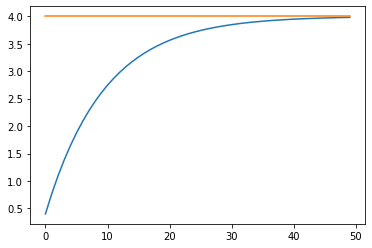

In [53]:
mean_t = torch.tensor(mean_l)
plt.plot(range(50),mean_t[:,1],torch.full_like(mean_t[:,1],torch.mean(f,0)[1]));

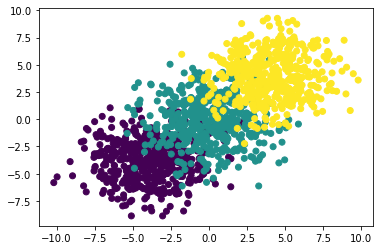

In [55]:
torch.manual_seed(420)

features,labels = tensorGenCla()
plt.scatter(features[:,0],features[:,1],c=labels);

In [56]:
train_loader, test_loader = split_loader(features,labels)

In [59]:
train_loader.dataset[:] # 训练集，其中有特征有标签(1500条)

(tensor([[-0.9717, -0.9087],
         [-6.2780, -5.3359],
         [ 2.3067, -2.8697],
         ...,
         [ 3.5654,  6.1413],
         [-3.7873, -1.9385],
         [-2.4863,  0.3824]]), tensor([[1],
         [0],
         [1],
         ...,
         [2],
         [0],
         [1]]))

In [57]:
features_train = train_loader.dataset[:][0]
features_train

tensor([[-0.9717, -0.9087],
        [-6.2780, -5.3359],
        [ 2.3067, -2.8697],
        ...,
        [ 3.5654,  6.1413],
        [-3.7873, -1.9385],
        [-2.4863,  0.3824]])

In [60]:
torch.mean(features_train,0),torch.var(features_train,0)

(tensor([0.0890, 0.0311]), tensor([14.7865, 14.2480]))

In [85]:
bn4 = nn.BatchNorm1d(2)

In [86]:
bn4.running_mean, bn4.running_var

(tensor([0., 0.]), tensor([1., 1.]))

In [77]:
for X,y in train_loader:
  temp = bn4(X)

In [78]:
bn4.running_mean, bn4.running_var

(tensor([0.5245, 0.3264]), tensor([14.5724, 12.6958]))

原始数据的均值和方差为<font color="orange">tensor([0.0890, 0.0311]), tensor([14.7865, 14.2480]))

In [87]:
torch.manual_seed(420)
for epochs in range(5):
  for X,y in train_loader:
    temp = bn4(X)

In [88]:
bn4.running_mean, bn4.running_var

(tensor([ 0.1794, -0.2990]), tensor([16.3008, 13.8976]))

### model.train()和model.eval()

PyTorch中适用于nn模块中所有模型的一种方法——model.train()与model.eval()。其中，model.train()表示开启模型训练模式，在默认情况下，我们实例化的每一个模型都是出于训练模式的，而model.eval()则表示将模型转化为测试模式

In [92]:
bn5 = nn.BatchNorm1d(3)
bn5.train()

BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [93]:
f

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [95]:
bn5 = nn.BatchNorm1d(3)
bn5.train()
bn5.running_mean, bn5.running_var

(tensor([0., 0., 0.]), tensor([1., 1., 1.]))

In [96]:
bn5(f)

tensor([[-1.2247, -1.2247, -1.2247],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.2247,  1.2247,  1.2247]], grad_fn=<NativeBatchNormBackward0>)

In [97]:
bn5.running_mean, bn5.running_var

(tensor([0.3000, 0.4000, 0.5000]), tensor([1.8000, 1.8000, 1.8000]))

In [98]:
bn5 = nn.BatchNorm1d(3)
bn5.eval()
bn5.running_mean, bn5.running_var

(tensor([0., 0., 0.]), tensor([1., 1., 1.]))

In [102]:
bn5(f) # 进行归一化的是初始的mean和var(0,1),且始终不变

tensor([[0.0000, 1.0000, 2.0000],
        [3.0000, 4.0000, 5.0000],
        [6.0000, 7.0000, 8.0000]], grad_fn=<NativeBatchNormBackward0>)

In [103]:
bn5.running_mean, bn5.running_var

(tensor([0., 0., 0.]), tensor([1., 1., 1.]))

In [104]:
bn5.training

False

## **利用nn.BatchNorm构建带BN的神经网络**

In [105]:
class net_class1(nn.Module):
  def __init__(self,act_fun=torch.relu,in_features=2,n_hidden=4,out_features=1,bias=True,BN_model=None,momentum=0.1):
    super(net_class1,self).__init__()
    self.linear1 = nn.Linear(in_features,n_hidden,bias=bias)
    self.normalize1 = nn.BatchNorm1d(n_hidden,momentum=momentum)
    self.linear2 = nn.Linear(n_hidden,out_features,bias=bias)
    self.BN_model = BN_model # 两个属性
    self.act_fun = act_fun
  
  def forward(self,x):
    if self.BN_model == None:
      z1 = self.linear1(x)
      p1 = self.act_fun(z1)
      out = self.linear2(p1)
    elif self.BN_model == "pre":
      z1 = self.normalize1(self.linear1(x))
      p1 = self.act_fun(z1)
      out = self.linear2(p1)
    elif self.BN_model == "post":
      z1 = self.linear(x)
      p1 = self.act_fun(z1)
      out = self.linear2(self.normalize1(p1))
    return out

In [106]:
torch.manual_seed(420)

features,labels = tensorGenReg(w=[2,-1],bias=False,deg=2)

train_loader,test_loader = split_loader(features,labels)

In [107]:
torch.manual_seed(24)
relu_model1_norm = net_class1(BN_model="pre")

In [108]:
# 设置模型为训练模式,每一个module都是training形式
relu_model1_norm.train()

net_class1(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [112]:
list(relu_model1_norm.modules())[2].running_mean, list(relu_model1_norm.modules())[2].running_var

(tensor([0., 0., 0., 0.]), tensor([1., 1., 1., 1.]))

In [113]:
list(relu_model1_norm.modules())[2].weight, list(relu_model1_norm.modules())[2].bias

(Parameter containing:
 tensor([1., 1., 1., 1.], requires_grad=True), Parameter containing:
 tensor([0., 0., 0., 0.], requires_grad=True))

In [115]:
fit(
    net=relu_model1_norm,
    criterion=nn.MSELoss(),
    optimizer=optim.SGD(relu_model1_norm.parameters(),lr=0.03),
    batchdata=train_loader,
    epochs=20,
    cla=False
)

In [116]:
list(relu_model1_norm.modules())[2].weight, list(relu_model1_norm.modules())[2].bias

(Parameter containing:
 tensor([2.0457, 2.8368, 3.2382, 2.0761], requires_grad=True),
 Parameter containing:
 tensor([-1.7242, -1.4776, -2.0089, -1.4371], requires_grad=True))

In [117]:
list(relu_model1_norm.modules())[2].running_mean, list(relu_model1_norm.modules())[2].running_var

(tensor([-0.1294, -0.2738, -0.1332,  0.0668]),
 tensor([4.4674, 6.4921, 7.3547, 4.8549]))

In [118]:
relu_model1_norm.eval()

net_class1(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (normalize1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [119]:
mse_cal(train_loader,relu_model1_norm)

tensor(0.5253, grad_fn=<MseLossBackward0>)

In [120]:
mse_cal(test_loader,relu_model1_norm)

tensor(0.9437, grad_fn=<MseLossBackward0>)

In [121]:
list(relu_model1_norm.modules())[2].weight, list(relu_model1_norm.modules())[2].bias,list(relu_model1_norm.modules())[2].running_mean, list(relu_model1_norm.modules())[2].running_var

(Parameter containing:
 tensor([2.0457, 2.8368, 3.2382, 2.0761], requires_grad=True),
 Parameter containing:
 tensor([-1.7242, -1.4776, -2.0089, -1.4371], requires_grad=True),
 tensor([-0.1294, -0.2738, -0.1332,  0.0668]),
 tensor([4.4674, 6.4921, 7.3547, 4.8549]))

In [123]:
torch.manual_seed(420)

features,labels = tensorGenReg(w=[2,-1],bias=False,deg=2)

train_loader,test_loader = split_loader(features,labels)

In [126]:
torch.manual_seed(24)

sigmoid_model1 = net_class1(act_fun=torch.sigmoid)
sigmoid_model1_norm = net_class1(act_fun=torch.sigmoid,BN_model="pre")

model_l = [sigmoid_model1,sigmoid_model1_norm]
name_l = ["sigmoid_model1","sigmoid_model1_norm"]

lr = 0.03
num_epochs = 40

train_l, test_l = model_comparison(
    model_l=model_l,
    name_l=name_l,
    train_data=train_loader,
    test_data=test_loader,
    criterion=nn.MSELoss(),
    num_epochs=num_epochs,
    optimizer=optim.SGD,
    lr=lr,
    cla=False,
    eva=mse_cal
)

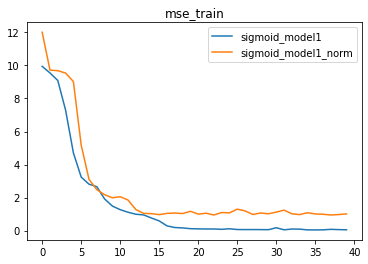

In [128]:
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), train_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_train');

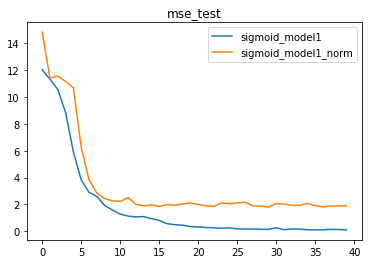

In [130]:
# 测试误差
for i, name in enumerate(name_l):
    plt.plot(list(range(num_epochs)), test_l[i], label=name)
plt.legend(loc = 1)
plt.title('mse_test');

In [ ]:
class net_class3(nn.Module):
  def __init__(self,act_fun=torch.relu,in_features=2,n_hidden1=4,n_hidden2=4,n_hidden3=4,out_features=1,bias=True,BN_model=None,momentum=0.1):
    super(net_class3,self).__init__()
    self.linear1 = nn.Linear(in_features,n_hidden1,bias=bias)
    self.normalize1 = nn.BatchNorm1d(n_hidden1,momentum=momentum)
    self.linear2 = nn.Linear(n_hidden1,n_hidden2,bias=bias)
    self.normalize2 = nn.BatchNorm1d(n_hidden2,momentum=momentum)
    self.linear3 = nn.Linear(n_hidden2,n_hidden3,bias=bias)
    self.normalize3 = nn.BatchNorm1d(n_hidden3,momentum=momentum)
    self.linear4 = nn.Linear(n_hidden3,out_features,bias=bias)
    self.BN_model = BN_model
    self.act_fun = act_fun

  def forward(self,x):
    if self.BN_model == None:
      z1 = self.linear1(x)
      p1 = self.act_fun(z1)
      z2 = self.linear2(p1)
      p2 = self.act_fun(z2)
      z3 = self.linear3(p2)
      p3 = self.act_fun(z3)
      out = self.linear4(p3)
    if self.BN_model == "pre":
      z1 = self.normalize1(self.linear1(x))
      p1 = self.act_fun(z1)
      z2 = self.normalize2(self.linear2(p1))
      p2 = self.act_fun(z2)
      z3 = self.normalize3(self.linear3(p2))
      p3 = self.act_fun(z3)
      out = self.linear4(p3)
    if self.BN_model == "post":
      z1 = self.linear1(x)
      p1 = self.act_fun(z1)
      z2 = self.normalize1(self.linear2(p1))
      p2 = self.act_fun(z2)
      z3 = self.normalize2(self.linear3(p2))
      p3 = self.act_fun(z3)
      out = self.normalize3(self.linear4(p3))
    return out